In [9]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn import linear_model
import random as rd


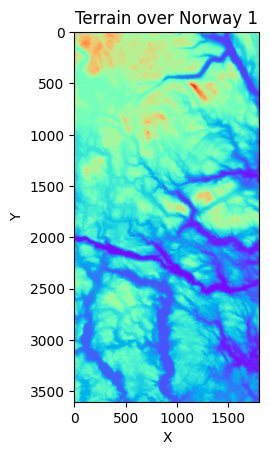

In [3]:
np.random.seed(1509)

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

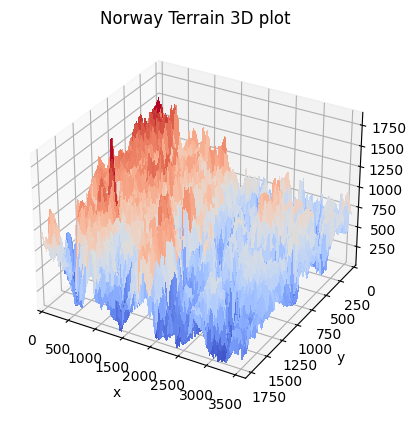

In [4]:
rows, cols = terrain1.shape

fig = plt.figure()
ax = fig.gca(projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

# Plot the surface.
surf = ax.plot_surface(x.T, y.T, terrain1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim(0,rows)
ax.set_ylim(cols, 0)

plt.title("Norway Terrain 3D plot")
plt.show()

(2000, 2)


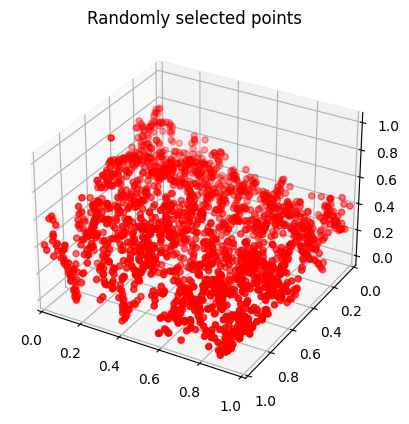

In [5]:
def min_max_scaler(data):
    """
    Perform Min-Max scaling on a given dataset.

    Min-Max scaling rescales the values in the input array 'X' to a given range
    .
    Parameters:
    x (np.array): The input dataset to be scaled.

    Returns:
    scaled(np.array): The scaled dataset with values in the range [0, 1].
    """
    min_i = min(data)
    max_i = max(data)
    
    scaled = (data-min_i)/(max_i-min_i)
    return scaled

def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

#Select n amount of data points to shorten running time
n = 2000

datapoints = np.zeros([n, 2])
z = np.zeros([n, 1])

datapoints = np.column_stack((np.random.randint(0, rows, size = n), np.random.randint(0, cols, size = n)))
print(datapoints.shape)
for i in range(n):
    z[i] = terrain1[int(datapoints[i, 0])][int(datapoints[i, 1])]

z = min_max_scaler(z)
datapoints = np.column_stack((min_max_scaler(datapoints[:,0]), min_max_scaler(datapoints[:,1])))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

scatter = ax.scatter(datapoints[:, 0], datapoints[:, 1], z, c='r', marker='o', label='Selected Points')
plt.title("Randomly selected points")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.show()


In [6]:
def c_tilde(deg, x):
    """
    Generate a subset of features from the input data matrix 'x' up to a specified degree 'deg',
    to use in predicting MSE and R2 score.

    Parameters:
    deg (int): The desired degree up to which features should be generated.
    x (np.array): The input data matrix containing one or more columns of features.

    Returns:
    c (int): The number of features generated up to degree 'i'.
    tilde (np.array): calculated tilde value of input
    """
    c = int((deg + 2) * (deg + 1) / 2)
    tilde = x[:,0:c-1]
    return c, tilde

PolynomialDegree = 20

#create design matrix X
X = create_X(datapoints[:, 0], datapoints[:, 1], PolynomialDegree)

#Remove intercept
X = X[:, 1:]

#Split into train and test sets
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

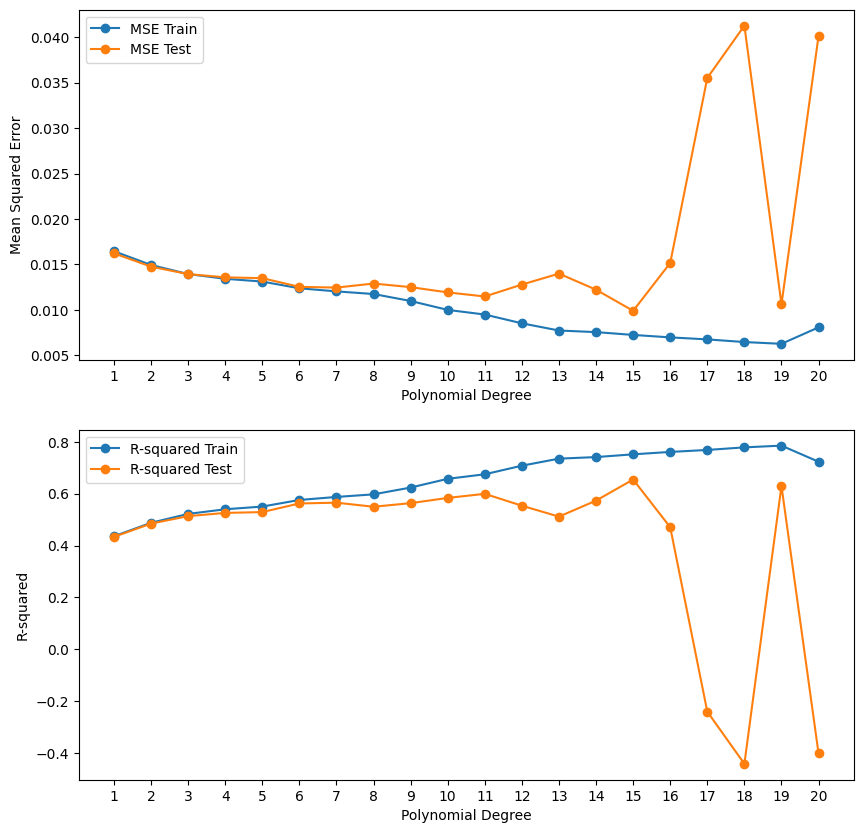

In [15]:
##OLS

MSETrain = np.zeros(PolynomialDegree)
MSETest = np.zeros(PolynomialDegree)
R2Train = np.zeros(PolynomialDegree)
R2Test = np.zeros(PolynomialDegree)

for degree in range(1, PolynomialDegree + 1):
    c, Xtilde = c_tilde(degree, x_train)

    model = LinearRegression(fit_intercept=True)
    model.fit(Xtilde, z_train)

    ztilde = model.predict(Xtilde)
    z_pred = model.predict(x_test[:, 0:c-1])

    MSETrain[degree-1] = mean_squared_error(z_train, ztilde)
    MSETest[degree-1] = mean_squared_error(z_test, z_pred)
    R2Train[degree-1] = r2_score(z_train, ztilde)
    R2Test[degree-1] = r2_score(z_test, z_pred)
degrees = np.arange(1, PolynomialDegree + 1)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot MSE for train and test data
axes[0].plot(degrees, MSETrain, label='MSE Train', marker='o')
axes[0].plot(degrees, MSETest, label='MSE Test', marker='o')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_xticks(ticks = degrees)
axes[0].legend()

# Plot R2 for train and test data
axes[1].plot(degrees, R2Train, label='R-squared Train', marker='o')
axes[1].plot(degrees, R2Test, label='R-squared Test', marker='o')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('R-squared')
axes[1].set_xticks(ticks = degrees)
axes[1].legend()


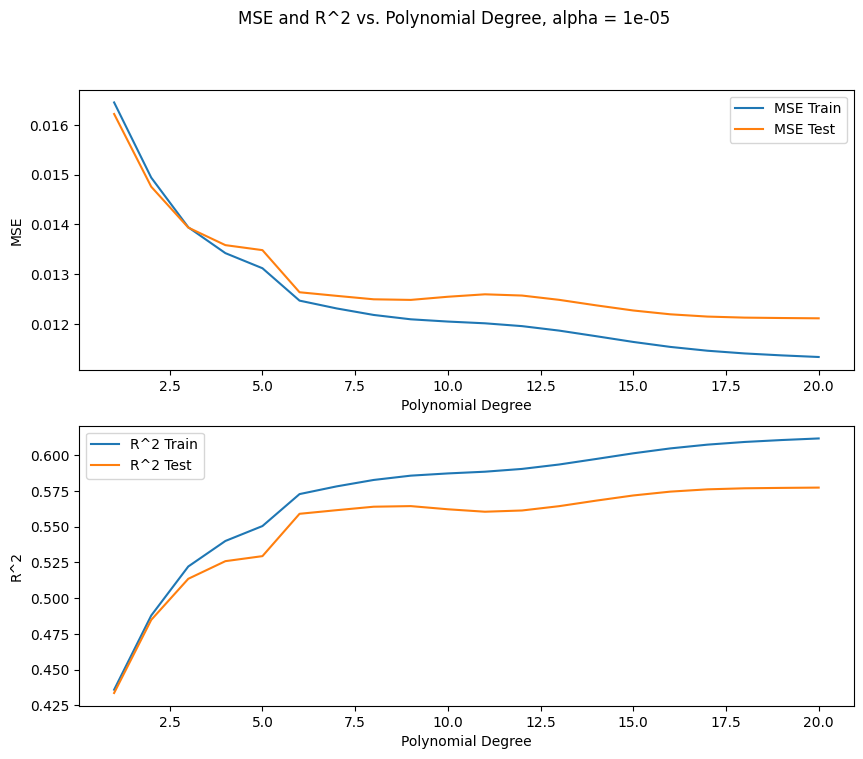

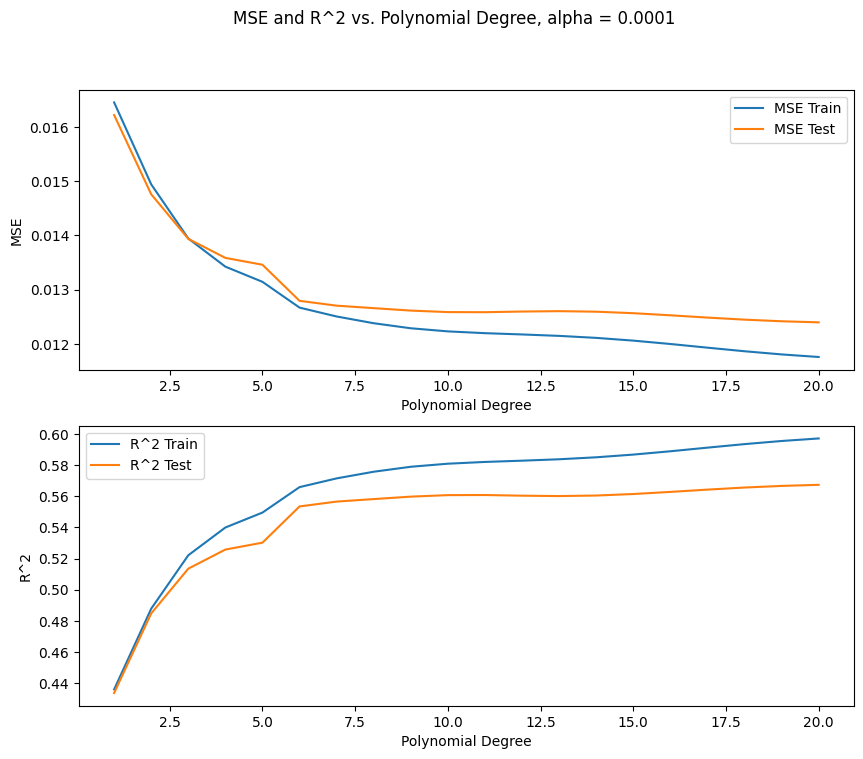

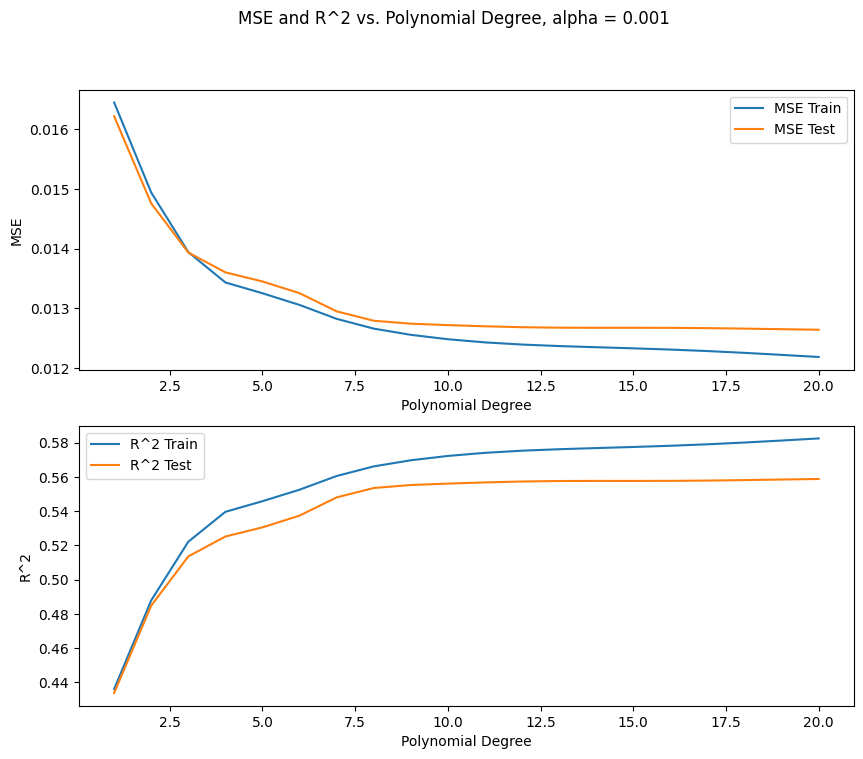

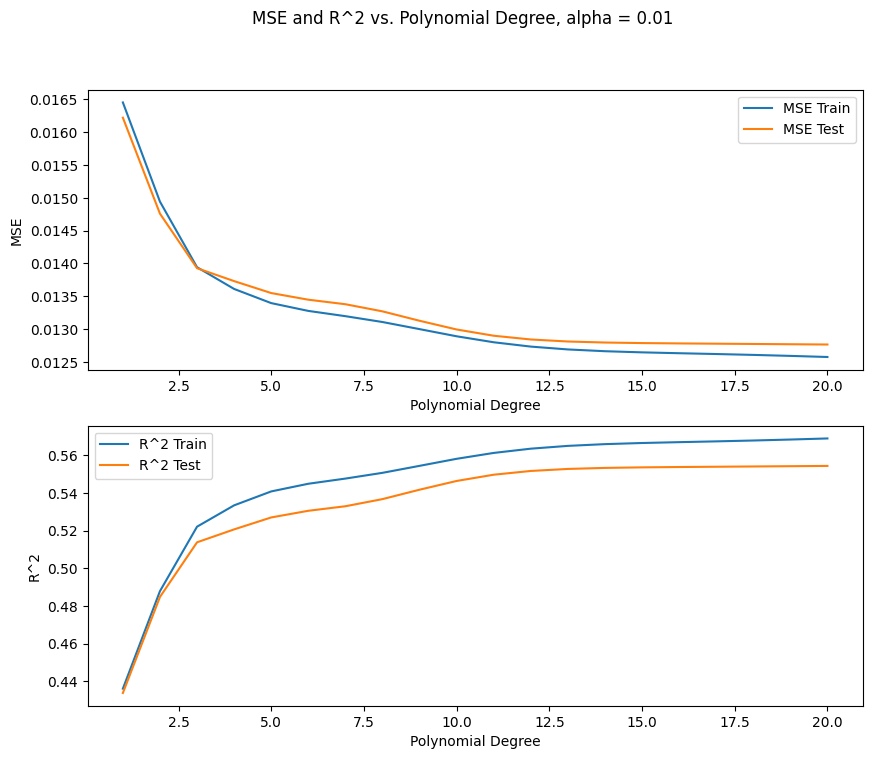

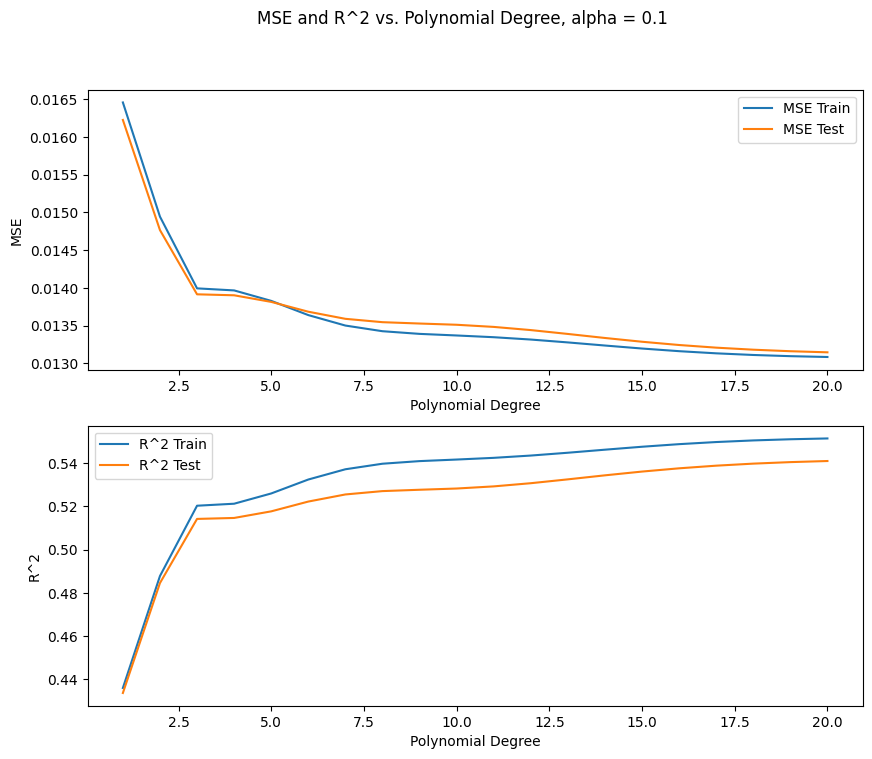

In [18]:
##Ridge
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

MSETrain = np.zeros((PolynomialDegree))
MSETest = np.zeros((PolynomialDegree))
R2Train = np.zeros((PolynomialDegree))
R2Test = np.zeros((PolynomialDegree))


for lmbd in lambdas:
    MSETrain = np.zeros((PolynomialDegree))
    MSETest = np.zeros((PolynomialDegree))
    R2Train = np.zeros((PolynomialDegree))
    R2Test = np.zeros((PolynomialDegree))
    PolyDegree = np.zeros((PolynomialDegree))

    for degree in range(1, PolynomialDegree + 1):    
        c, Xtilde = c_tilde(degree, x_train)
        model = linear_model.Lasso(lmbd)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain[degree -1] = mean_squared_error(z_train, ztilde)
        MSETest[degree-1] = mean_squared_error(z_test, z_pred)
        R2Train[degree-1] = r2_score(z_train, ztilde)
        R2Test[degree-1] = r2_score(z_test, z_pred)
        PolyDegree[degree-1] = degree

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(PolyDegree, MSETrain, label='MSE Train')
    ax1.plot(PolyDegree, MSETest, label='MSE Test')
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax2.plot(PolyDegree, R2Train, label='R^2 Train')
    ax2.plot(PolyDegree, R2Test, label='R^2 Test')
    ax2.set_xlabel('Polynomial Degree')
    ax2.set_ylabel('R^2')
    ax2.legend()
    plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lmbd}")

    plt.show()

        




C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.588e+00, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.928e+00, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pac

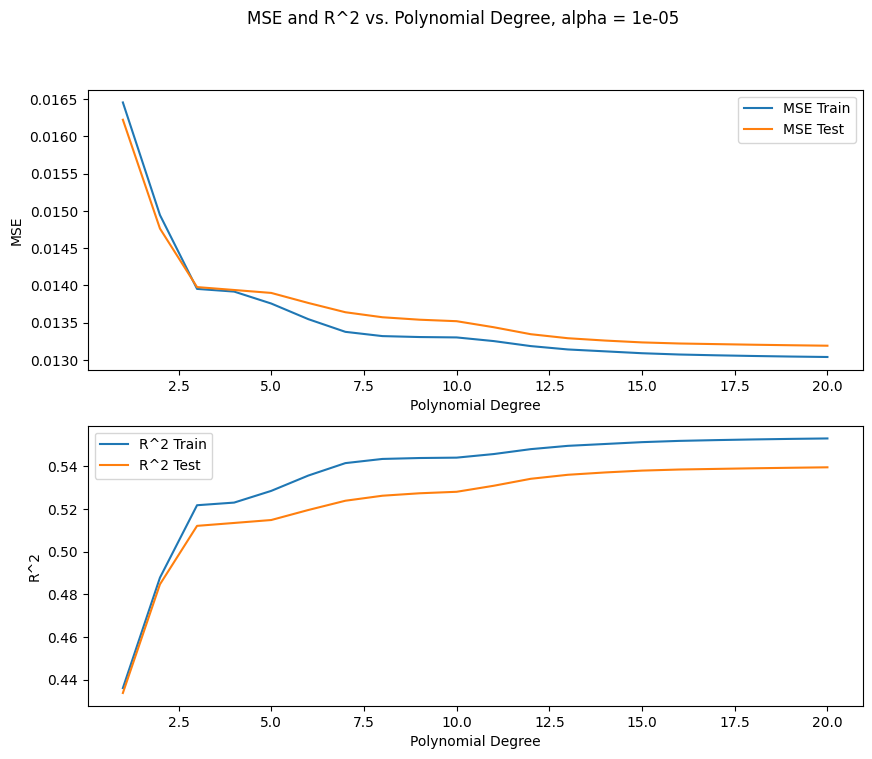

C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.985e-02, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e-01, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pac

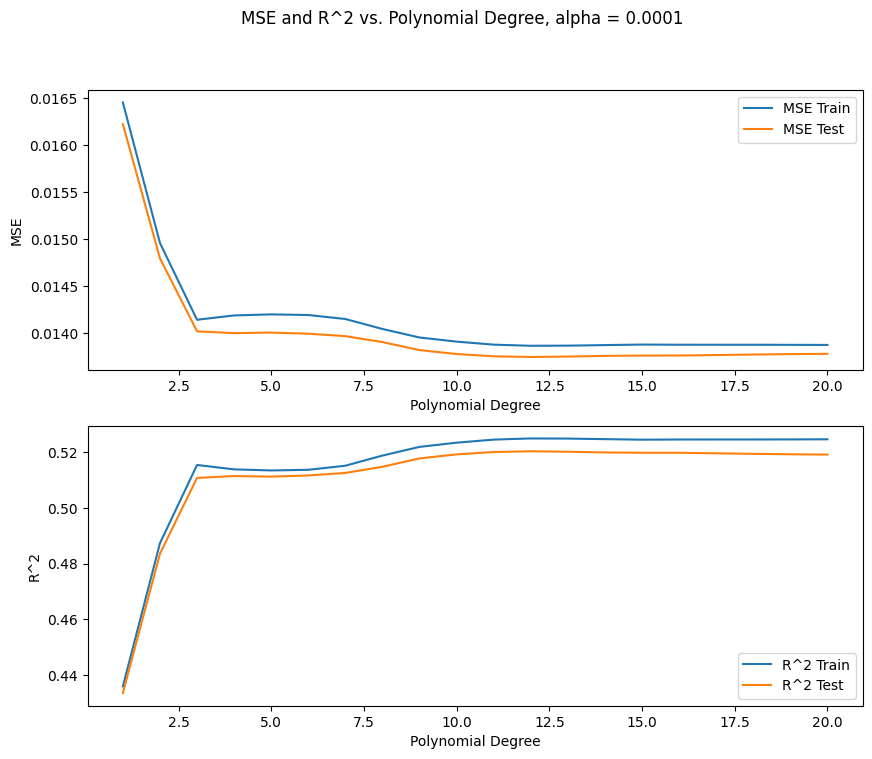

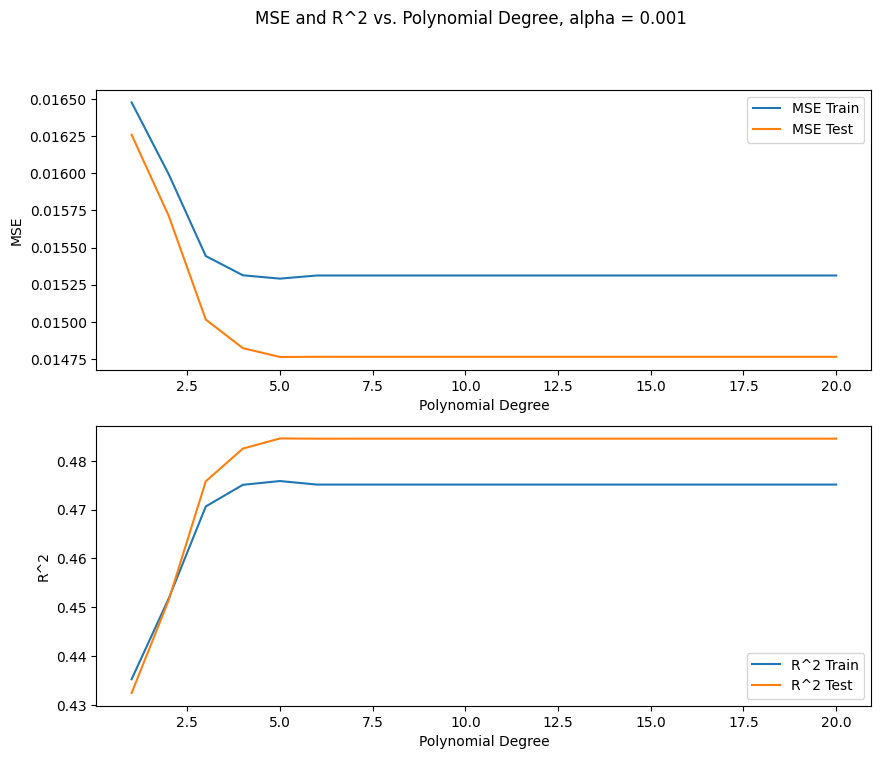

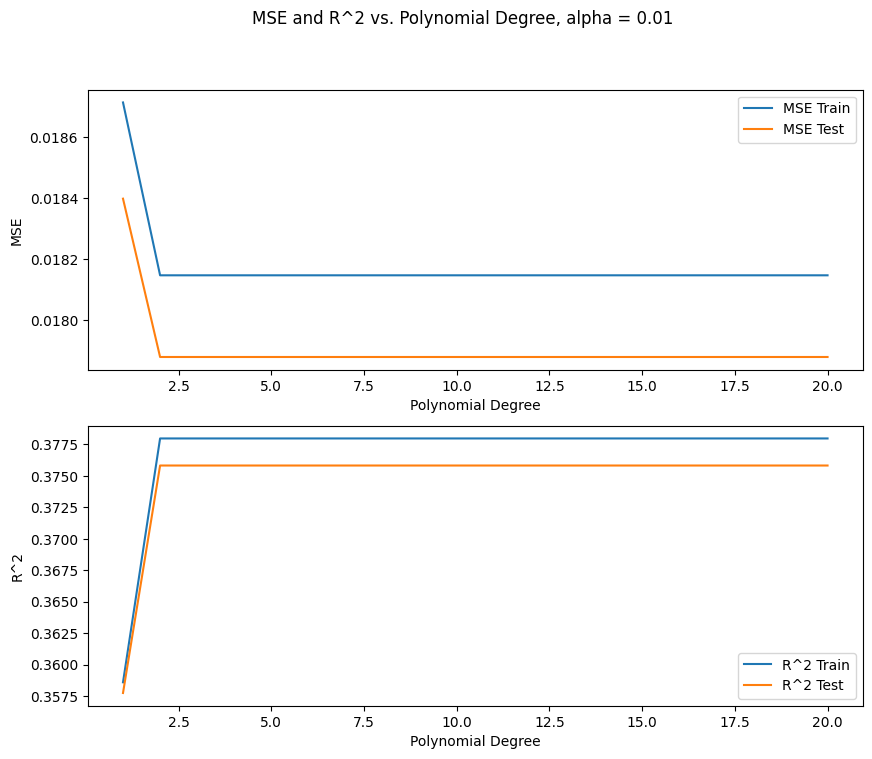

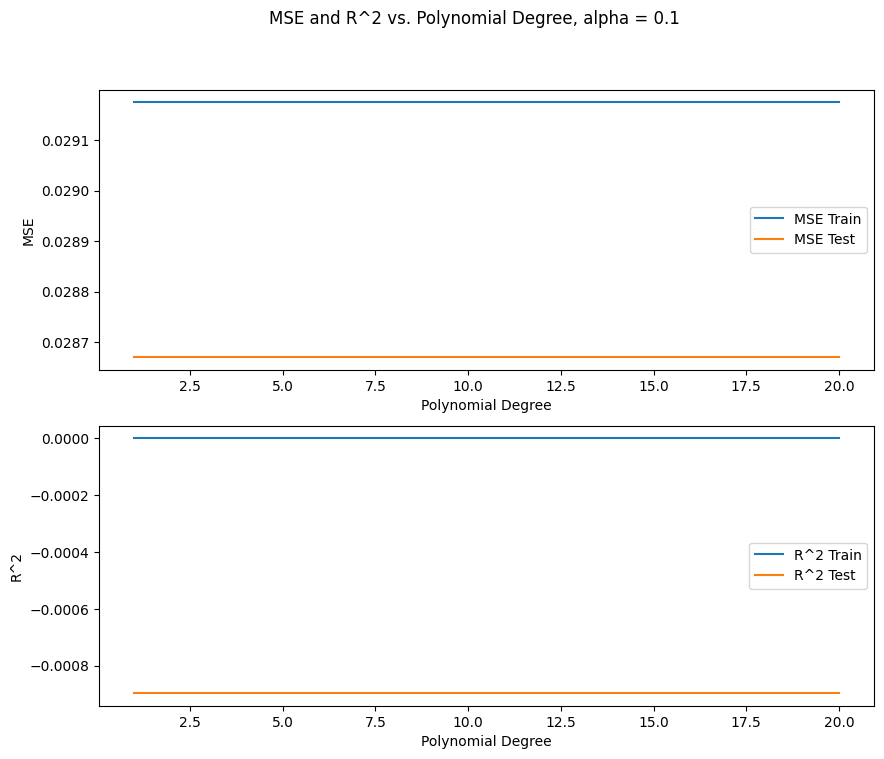

In [19]:
##Lasso
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

MSETrain = np.zeros((PolynomialDegree))
MSETest = np.zeros((PolynomialDegree))
R2Train = np.zeros((PolynomialDegree))
R2Test = np.zeros((PolynomialDegree))


for lmbd in lambdas:
    MSETrain = np.zeros((PolynomialDegree))
    MSETest = np.zeros((PolynomialDegree))
    R2Train = np.zeros((PolynomialDegree))
    R2Test = np.zeros((PolynomialDegree))
    PolyDegree = np.zeros((PolynomialDegree))

    for degree in range(1, PolynomialDegree + 1):    
        c, Xtilde = c_tilde(degree, x_train)
        model = linear_model.Lasso(lmbd)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain[degree -1] = mean_squared_error(z_train, ztilde)
        MSETest[degree-1] = mean_squared_error(z_test, z_pred)
        R2Train[degree-1] = r2_score(z_train, ztilde)
        R2Test[degree-1] = r2_score(z_test, z_pred)
        PolyDegree[degree-1] = degree

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(PolyDegree, MSETrain, label='MSE Train')
    ax1.plot(PolyDegree, MSETest, label='MSE Test')
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax2.plot(PolyDegree, R2Train, label='R^2 Train')
    ax2.plot(PolyDegree, R2Test, label='R^2 Test')
    ax2.set_xlabel('Polynomial Degree')
    ax2.set_ylabel('R^2')
    ax2.legend()
    plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lmbd}")

    plt.show()

        
